In [1]:
from hyperobjects import *
import numpy as np

np.random.seed(26)

In [45]:
from scipy.spatial.transform import Rotation
RO1 = Rotation.from_euler("xyz", [10,10,30], degrees=True).as_matrix()
RO2 = Rotation.from_euler("xyz", [-5,4,80], degrees=True).as_matrix()
RI1 = Rotation.from_euler("xyz", [1,-50,30], degrees=True).as_matrix()
RI2 = Rotation.from_euler("xyz", [12,-8,-3], degrees=True).as_matrix()
TO1 = AffineMap(RO1, [1,1,2])
TO2 = AffineMap(RO1, [-1,4,1])
TI1 = AffineMap(RI1, [4,5,1])
TI2 = AffineMap(RI2, [2,15,1])

# Both points are expressed as points in their respective body
O = np.array([1,2,3])
I = np.array([1,-1,8])

# Vectors of rotation
W1 = np.random.uniform(size=(3,3))
W2 = np.random.uniform(size=(3,3))

# Let g1, g2 be points expressed in the joint frame such that
g1 = 5 * W1 @ (np.cross(TO1(O), TI1(I)))
g2 = 10 * W2 @ (np.cross(TO2(O), TI2(I)))

# We displace the points g1, g2 to give u1, u2
u1 = np.linalg.inv(W1) @ g1
u2 = np.linalg.inv(W2) @ g2

# We retrieve the 
P1 = ~Line(u1) # Expressed in w body
P2 = ~Line(u2) # same

inter_O = TO1.T(P1) & TO2.T(P2)
inter_I = TI1.T(P1) & TI2.T(P2)

# # print((O - inter_O.location) in (inter_O-inter_O.location))
print("O in TO1.T(P1):", O in TO1.T(P1), "| O in TO2.T(P2):", O in TO2.T(P2))
print("I in TI1.T(P1):", I in TI1.T(P1), "| I in TI2.T(P2):", I in TI2.T(P2))

print("O in inter", O in inter_O)
print("I in inter", I in inter_I)

print(inter_O.basis.ravel(), inter_O.location)
print(Line(O - inter_O.location).is_parallel(inter_O))

O in TO1.T(P1): True | O in TO2.T(P2): True
I in TI1.T(P1): True | I in TI2.T(P2): True
O in inter True
I in inter True
[-0.66041 -0.46764 -0.58751] [-1.21781  0.42955  1.027  ]
True


In [46]:
p, n, m = 2,3,4
J = np.random.uniform(size=(p, n))

np.random.seed(42)
N1 = np.random.uniform(size=(n, m))
N1 = np.identity(m)[[0,1,2], :]

u,s,vt = np.linalg.svd(np.random.uniform(size=(m,m)))
N2 = N1 @ vt
phi = AffineMap(J.T)
psi1 = AffineMap(N1, [5,0,0])
psi2 = AffineMap(N2, [1,0.5,0])

C = Cube(m)
Z1 = psi1(C)
P1 = im(phi) & Z1

Z2 = psi2(C)
P2 = im(phi) & Z2

from pycapacity.human import force_polytope
from pycapacity.visual import plot_polytope


K = ~psi2.T(~im(phi))
K_r = vt @ K
# print(K.location)
# Pi = SkuricPolytope(vertices=N1 @ force_polytope(K.basis.T, np.identity(m), -0.5*np.ones(m) + (K_r.location), 0.5*np.ones(m) + (K_r.location), tol=0.0001).muscle_force_vertices)

In [72]:
print(psi1.pinv@psi1.translation)
print(psi1(K1.location))
K1 = ~psi1.T(~im(phi))
K2 = ~psi2.T(~im(phi))
uK1, sK1, vtK1 = np.linalg.svd(K1.basis)
uK2, sK2, vtK2 = np.linalg.svd(K2.basis)
print(K1.location, K2.location)
print(K1.is_parallel(K2))
K1_in_0 = uK1.T @ (K1 - K1.location)
K2_in_0 = uK2.T @ (K2 - K2.location)
uK2, sK2, vtK2 = np.linalg.svd(K2_in_0.basis)
print(K1_in_0.location)
print(K2_in_0.location)
print(K1_in_0.is_parallel(K2_in_0))


bounds = 0.5*np.vstack([-np.ones(m), np.ones(m)]).T
C1 = uK1.T @ (bounds - K1.location.reshape((-1,1)))
C2 = uK2.T @ (bounds - K2.location.reshape((-1,1)))
print(C1)
print(C2)

CP1_H = 0.5*np.vstack([-np.identity(m), np.identity(m)])
CP1_b = CP1_H @ (0.5*np.ones(m) + 100*np.ones(m))
print(CP1_b)

# print(CP1_H)
# - (K2.location - K1.location)
# print(K2_in_K1.location)


[5. 0. 0. 0.]
[0. 0. 0.]
[-5.  0.  0.  0.] [0.30978 0.87604 0.34759 0.51553]
False
[0. 0. 0. 0.]
[0. 0. 0. 0.]
True
[[-2.28312 -3.68697]
 [ 0.56502 -0.42554]
 [-0.5      0.5    ]
 [ 3.90104  4.12009]]
[[ 0.216    0.26756]
 [-1.02769  0.22719]
 [ 1.47133  0.2786 ]
 [-1.01553 -0.01553]]
[-50.25 -50.25 -50.25 -50.25  50.25  50.25  50.25  50.25]


In [70]:
from scipy.spatial import HalfspaceIntersection
from scipy.optimize import linprog

H = np.random.uniform(-10, 40, size=(500,301)) + 1000*np.ones(500).reshape((-1,1))
b = np.random.uniform(500, 700, size=500)

# print(H[:,:-1].shape)
# j = HalfspaceIntersection(H, )
res = linprog(c=np.zeros(CP1_H.shape[1]), A_ub=CP1_H, b_ub=CP1_b)
print(res)

       message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
       success: True
        status: 0
           fun: 0.0
             x: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
           nit: 0
         lower:  residual: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
                marginals: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
         upper:  residual: [       inf        inf        inf        inf]
                marginals: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
         eqlin:  residual: []
                marginals: []
       ineqlin:  residual: [ 5.250e+00  5.250e+00  5.250e+00  5.250e+00
                             5.250e+00  5.250e+00  5.250e+00  5.250e+00]
                marginals: [-0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00
                            -0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00]


In [55]:
H = HyperPlane([0.5,0,0,0,-0.25])
print(H.basis)
print(H.location)

[[ 0.  0.  0.]
 [-1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0. -1.]]
[0.5 0.  0.  0. ]


In [47]:
%matplotlib qt5

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1, projection="3d")
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
im(phi).plot(ax, alpha=0.1)
# Z.plot(ax,in_intermediate_space=True, color="blue", alpha=0.2)
# E.plot(ax, color="blue", alpha=0.2)
P1.plot(ax, in_intermediate_space=True, color="red", tol=0.001, alpha=0.1)
P2.plot(ax, in_intermediate_space=True, color="purple", tol=0.001, alpha=0.1)
# plot_polytope(polytope=Pi, plot=ax, alpha=0.5)
# Z1.plot(ax, in_intermediate_space=True,color="blue", tol=0.0001, alpha=0.05)
# Z2.plot(ax, in_intermediate_space=True,color="green", tol=0.0001, alpha=0.05)
# E1f.plot(ax, color="green", alpha=0.5)
# E2f.plot(ax, color="green", alpha=0.5)
# P3.plot(ax, in_intermediate_space=False, color="black", tol=0.01, alpha=0.1)

ValueError: shapes (2,4) and (0,) not aligned: 4 (dim 1) != 0 (dim 0)

In [471]:
print(np.sqrt(2))
print(1/np.sqrt(2))

1.4142135623730951
0.7071067811865475


In [512]:
K1 = ~psi1.T(~im(phi))
K2 = ~psi2.T(~im(phi))
# print(K1.basis.round(3), K1.location.round(2))
print(K1.location.round(2))
print(K2.location.round(2))

K = K1 & K2

O = np.zeros(m)
dist = np.linalg.norm((K1 << K2.location) - K2.location)
print(dist)
dist = np.linalg.norm((K2 << K1.location) - K1.location)
print(dist)
print(K1.is_parallel(K2))

# Kp = (~K1_) & (~K2)
# Kp2 = (K1) & (~K2_)
# Kp3 = (~K1_) & (K2)
# print(K.basis.round(2))
# print(K.location.round(2))
# print(np.any(K.location > 0.5))
# print(np.any(K.location < -0.5))
# print("K center in cube: ", not np.any(K.location > 0.5) and not np.any(K.location < -0.5))
# print("Kp center in cube: ", not np.any(Kp.location > 0.5) and not np.any(Kp.location < -0.5))
print("Kp2 center in cube: ", not np.any(Kp2.location > 0.5) and not np.any(Kp2.location < -0.5))
print("Kp3 center in cube: ", not np.any(Kp3.location > 0.5) and not np.any(Kp3.location < -0.5))

[0. 0. 0. 0. 0.]
[-1.  0.  0.  0.  0.]
0.6412107098185295
0.6412107098185295
True
Kp2 center in cube:  True
Kp3 center in cube:  True


In [513]:
(np.sqrt(2) + 1)/np.sqrt(2)

1.7071067811865472

In [465]:
np.exp(1)/4

0.6795704571147613

In [466]:
# print(2*np.linalg.norm(K1 << K2.location))
print(2*np.linalg.norm(K2 << K1.location))
print(np.linalg.norm(K2 << K1.location))

1.4206540023260403
0.7103270011630202


In [431]:
np.sqrt(2)/2

0.7071067811865476

In [432]:
np.sin(np.pi/4)

0.7071067811865476

In [433]:
print(np.linalg.norm(K1 << K2.location))
print(np.linalg.norm(K2 << K1.location))

0.5497824029980664
0.7102834288885471


In [ ]:
0.42930318411340757 

0.43 en collision
0.54 pas en collision
0.62 pas en collision
0.91 pas en collision

0.36 en collision

In [10]:
from primitive2 import *
import numpy as np
import pycapacity.algorithms
from pycapacity.objects import Polytope as SkuricPolytope
import pycapacity.visual



In [11]:
%matplotlib qt5

np.random.seed(35)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1, projection="3d")

ax.set_xlim(-3, 5)
ax.set_ylim(-3, 5)
ax.set_zlim(-3, 5)

p, n, m = 2, 3, 7


phi = AffineMap(np.random.uniform(-1,0.5,size=(n,p)))
psi = AffineMap(np.random.uniform(-1,2, size=(n,m)), [0,4,-2])

Z = Zonotope(psi)
Z.plot(ax, color="green", alpha=0.2)

im(phi).plot(ax, color="red", alpha=0.2)

P = Polytope(phi, psi)
P.plot(ax, in_intermediate_space=True, color="red", alpha=0.2)

E_tau = psi(radius_grunbaum(m) * 0.5*Sphere(m))
E_tau.plot(ax, color="black", alpha=0.2)

(E_tau & im(phi)).plot(ax, color="red")

Point([0,0,0]).plot(color="black")

print((im(phi)).basis.shape)
print((~im(phi)).basis.shape)
print(psi.T.matrix.shape)
K = ~psi.T(~im(phi))
f = AffineMap(phi.pinv @ psi.matrix)
# f = phi.pinv @ psi

print(K.location)
# bias = f.translation
b_min, b_max = np.array([[-0.5,0.5]] * m).T
vert, H, d, faces , F_vert, t_vert = pycapacity.algorithms.iterative_convex_hull_method(K.basis, np.identity(m), b_min-K.location, b_max-K.location, tol=0.2)
pol = SkuricPolytope(vertices=phi.matrix @ f(F_vert))
pol.torque_vertices = t_vert
pol.muscle_force_vertices = F_vert

pycapacity.visual.plot_polytope(polytope=pol, plot=ax, face_color="blue", alpha=0.5)

# a = 2
# center_Z = Point(psi(np.zeros(m)))
# center_Z.plot(color="red")
# dist_phi_Z = (im(phi) << center_Z).location
# dist_phi2_Z2 = a * dist_phi_Z


# phi2 = AffineMap(phi.matrix)
# psi2 = AffineMap(a*psi.matrix, a*psi.translation)
# # Z2 = Zonotope(psi2)
# # Z2.plot(ax, color="green", alpha=0.1)

# center_Z2 = Point(psi2(np.zeros(m)))

# # Move both a*zonotope and im(phi)
# T1 = center_Z.location - center_Z2.location
# phi2 = AffineMap(phi2.matrix, T1)
# psi2 = AffineMap(np.identity(n), T1) @ psi2

# Z2 = Zonotope(psi2)
# Z2.plot(ax, color="violet", alpha=0.1)
# # phi2 = phi
# im(phi2).plot(color="black", alpha=0.1)
# # @ AffineMap(np.identity(m), np.linalg.pinv(psi.matrix)@(psi.translation) )
# # new_center_cube = np.linalg.pinv(psi2.matrix)@newT

# # T = AffineMap(np.identity(3), -psi.translation)
# P2 = Polytope(phi2, psi2)
# P2.plot(ax, tol=0.1, in_intermediate_space=True, color="violet", alpha=0.2)


In [ ]:
%matplotlib qt5

np.random.seed(7)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1, projection="3d")

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

p, n, m = 2, 3, 7

ax.scatter(0,0,0, c="red", s=10)

phi = AffineMap(np.random.uniform(-0.1,0.5,size=(n,p)))
psi = AffineMap(np.random.uniform(-0.5,0.5, size=(n,m)), [1,0,0])

Z = Zonotope(psi)
Z.plot(ax, color="green", alpha=0.2)

im(phi).plot(ax, color="red", alpha=0.2)

P = Polytope(phi, psi)
P.plot(ax, in_intermediate_space=True, tol=0.0001,color="red", alpha=0.2)

### ELLIPSOID WORKS
# E_tau = psi(radius_grunbaum(m) * 0.5*Sphere(m))
# E_tau.plot(ax, color="black", alpha=0.2)

# (E_tau & im(phi)).plot(ax, color="red")

# Point([0,0,0]).plot(color="black")

# print((im(phi)).basis.shape)
# print((~im(phi)).basis.shape)
# print(psi.T.matrix.shape)

## CHECK THE K CONSTRUCTION
# K = ~psi.T(~im(phi))
# f = AffineMap(phi.pinv @ psi.matrix)
# print(K.location)
# # bias = f.translation
# b_min, b_max = np.array([[-0.5,0.5]] * m).T
# vert, H, d, faces , F_vert, t_vert = pycapacity.algorithms.iterative_convex_hull_method(K.basis, np.identity(m), b_min-K.location, b_max-K.location, tol=0.1)
# pol = SkuricPolytope(vertices=phi.matrix @ f(F_vert))
# pol.torque_vertices = t_vert
# pol.muscle_force_vertices = F_vert
# pycapacity.visual.plot_polytope(polytope=pol, plot=ax, face_color="blue", alpha=0.5)

##TRANSLATION IS WORKING
# phi_x = phi(np.array([1,0]))
# phi_y = phi(np.array([0,1]))
# ax.plot([0,phi_x[0]], [0,phi_x[1]], [0,phi_x[2]], c="red")
# ax.plot([0,phi_y[0]], [0,phi_y[1]], [0,phi_y[2]], c="green")

# phi2 = phi
# psi2 = AffineMap(psi.matrix, psi.translation + phi_x)
# P_x = Polytope(phi2, psi2)
# P_x.plot(ax, in_intermediate_space=True, color="red")

# phi3 = phi
# psi3 = AffineMap(psi.matrix, psi.translation + phi_y)
# P_y = Polytope(phi3, psi3)
# P_y.plot(ax, in_intermediate_space=True, color="green")

### ROTATION
## USING https://math.stackexchange.com/questions/598750/finding-the-rotation-matrix-in-n-dimensions
# UV = (im(phi)).basis @(np.identity(2)) 
# U, V = UV.T
# ax.plot([0, U[0]], [0, U[1]], [0, U[2]], c="red")
# ax.plot([0, V[0]], [0, V[1]], [0, V[2]], c="green")

# theta = np.pi/2 # Be careful: does not correspond to pi/2 in R3!!
# Rt = np.array([
#     [np.cos(theta), -np.sin(theta)],
#     [np.sin(theta), np.cos(theta)]
# ])
# R = np.identity(n) - np.outer(U,U) - np.outer(V,V) + UV @ Rt @ UV.T
# print()

# # The center of the zonotope is also translated, since it is better
# # for visualisation in 3D, but it not mandatory.
# psi_rot = AffineMap(R@psi.matrix, R@psi.translation)
# Z_rot = Zonotope(psi_rot)
# Z_rot.plot(ax, color="violet", alpha=0.2)

# P = Polytope(phi, psi_rot)
# P.plot(ax, in_intermediate_space=True, color="green", tol=0.001, alpha=0.2)

### Zonotope Translation: 
### Translate Z along the vector from Z center to its orthogonal projection onto im(phi)
### NB: translation along im(phi) results in a translation of the polytope.
# Z_center = psi(np.zeros(m))
# Z_center_on_phi = im(phi) << Z_center
# axis = Z_center_on_phi - Z_center
# axis = axis/np.linalg.norm(axis)
# a = 0.5
# psi_translated = AffineMap(psi.matrix, psi.translation + a*axis)
# Zonotope(psi_translated).plot(ax, color="red", tol=0.01, alpha=0.2)
# P = Polytope(phi, psi_translated)
# P.plot(ax, in_intermediate_space=True, color="black", tol=0.001, alpha=0.2)


### Zonotope Scaling with adjustment (= polytope scaling)
a = 0.5
Z_center = psi(np.zeros(m))
Z_center_on_phi = im(phi) << Z_center
axis = Z_center_on_phi - Z_center

psi_lambda = AffineMap(a*psi.matrix, psi.translation - (a-1)*axis)
Zonotope(psi_lambda).plot(ax, color="red", alpha=0.1, tol=0.01)
P_y = Polytope(phi, psi_lambda)
P_y.plot(ax, in_intermediate_space=True, color="black", alpha=0.2, tol=0.01)

Visual: no faces found, calculating faces
using provided 3d axis
Visual: no faces found, calculating faces
using provided 3d axis
Visual: no faces found, calculating faces
using provided 3d axis
Visual: no faces found, calculating faces
using provided 3d axis


In [ ]:
R

array([[ 0.99706073,  0.00883952,  0.02639153],
       [ 0.00883952,  0.97341615, -0.07936954],
       [ 0.02639153, -0.07936954,  0.76303189]])

In [ ]:
print(l/1.8)
print(np.sqrt(l))

1.0
1.3416407864998738


In [ ]:
1/(1.2)

0.8333333333333334

In [ ]:
K

NameError: name 'K' is not defined

In [ ]:
%matplotlib qt5

np.random.seed(35)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1, projection="3d")

ax.set_xlim(-3, 5)
ax.set_ylim(-3, 5)
ax.set_zlim(-3, 5)

p, n, m = 2, 3, 10


phi = AffineMap(np.random.uniform(-1,0.5,size=(n,p)))
psi = AffineMap(np.random.uniform(-1,1, size=(n,m)), [0,4,-2])

Z = Zonotope(psi)
Z.plot(ax, color="green", alpha=0.2)

im(phi).plot(ax, color="red", alpha=0.2)

P = Polytope(phi, psi)
P.plot(ax, in_intermediate_space=True, color="red", alpha=0.2)

E_tau = psi(radius_grunbaum(m) * 0.5*Sphere(m))
E_tau.plot(ax, color="black", alpha=0.2)

(E_tau & im(phi)).plot(ax, color="red")

Point([0,0,0]).plot(color="black")


Visual: no faces found, calculating faces
using provided 3d axis
Visual: no faces found, calculating faces
using provided 3d axis


In [ ]:
%matplotlib qt5

np.random.seed(18)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1, projection="3d")

# ax.set_xlim(-3, 5)
# ax.set_ylim(-3, 5)
# ax.set_zlim(-3, 5)

p, n, m = 2, 3, 20

phi = AffineMap(np.random.uniform(-1,0.5,size=(n,p)))
psi = AffineMap(np.random.uniform(-1,1, size=(n,m)), [0,5,-1])

Z = Zonotope(psi)
Z.plot(ax, color="green", alpha=0.2)

im(phi).plot(ax, color="red", alpha=0.2)

P = Polytope(phi, psi)
P.plot(ax, in_intermediate_space=True, color="red", alpha=0.2)

E_tau = psi(radius_grunbaum(m) * 0.5*Sphere(m))
E_tau.plot(ax, color="black", alpha=0.2)

(E_tau & im(phi)).plot(ax, color="red")

Point([0,0,0]).plot(color="black")

K = ~psi.T(~im(phi))
f = AffineMap(phi.pinv @ psi.matrix)

# b_min, b_max = np.array([[-0.5,0.5]] * m).T
# vert, H, d, faces , F_vert, t_vert = pycapacity.algorithms.iterative_convex_hull_method(K.basis, np.identity(m), b_min-K.location, b_max-K.location, tol=0.2)
# pol = SkuricPolytope(vertices=phi.matrix @ f(F_vert))
# pol.torque_vertices = t_vert
# pol.muscle_force_vertices = F_vert

# pycapacity.visual.plot_polytope(polytope=pol, plot=ax, face_color="blue", alpha=0.5)
print(K.location)
E_K = K & (radius_grunbaum(m) * 0.9* 0.5 * Sphere(m))

# print(E_K)
# E_f = phi.matrix @ f(E_K)
E_f = psi(E_K)
E_f.plot(ax, color="green")

Visual: no faces found, calculating faces
using provided 3d axis
Visual: no faces found, calculating faces
using provided 3d axis
[ 0.14638445 -0.62844372  0.54293045 -0.58138372  0.24947855  0.37116779
  0.20094065 -0.30721765  0.22258226  0.53323992 -0.40849225 -0.36655012
  0.06445055 -0.28843606  0.94566806 -0.23399973 -0.19802911  0.87444581
  1.09480817  0.31436894]


In [ ]:
vol = 1
a = 10
r1 = (1/np.sqrt(np.pi))*(gamma(a/2 + 1)**(1/a))*(vol**(1/a))
print(r1)

r2 = radius_grunbaum(a)
print(r2)

r3 = (gamma(a/2 + 1) / np.sqrt(np.pi**a))**(1/a)
print(r3)

r4 = (gamma(a/2 + 1))/(gamma(a/2 + 1/2) * np.sqrt(np.pi))
print(r4)

r5 = ((gamma(a/2 + 1))**(1/a))/np.sqrt(np.pi)
print(r5)

p=2
r6 = gamma(a/p + 1)**(1/a) / (2*gamma(1/p + 1))
print(r6)

0.9106325886214025
2.5868993924777914
0.9106325886214025
1.2934496962388955
0.9106325886214026
0.9106325886214026


In [ ]:
gamma(1/2)

1.7724538509055159

In [ ]:
%matplotlib qt5

np.random.seed(30)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1, projection="3d")

ax.set_xlim(-5, 7)
ax.set_ylim(-5, 7)
ax.set_zlim(-5, 7)


P2 = Polytope(phi2, psi2)
P2.plot(ax, tol=1, color="violet", alpha=0.2)

NameError: name 'phi2' is not defined

In [ ]:
# [-0.26114146 -5.53826811 -2.93652823]
(im(phi) << Point(im(phi2).location)).location

Traceback (most recent call last):
  File "c:\Users\glaisne\mambaforge\envs\workspace\Lib\site-packages\matplotlib\backends\backend_qt.py", line 459, in _draw_idle
    self.draw()
  File "c:\Users\glaisne\mambaforge\envs\workspace\Lib\site-packages\matplotlib\backends\backend_agg.py", line 388, in draw
    self.figure.draw(self.renderer)
  File "c:\Users\glaisne\mambaforge\envs\workspace\Lib\site-packages\matplotlib\artist.py", line 95, in draw_wrapper
    result = draw(artist, renderer, *args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\glaisne\mambaforge\envs\workspace\Lib\site-packages\matplotlib\artist.py", line 72, in draw_wrapper
    return draw(artist, renderer)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\glaisne\mambaforge\envs\workspace\Lib\site-packages\matplotlib\figure.py", line 3154, in draw
    mimage._draw_list_compositing_images(
  File "c:\Users\glaisne\mambaforge\envs\workspace\Lib\site-packages\matplotlib\image.py", line 132

array([-2.83794643, -4.87506004, -2.12612446])

In [ ]:
a,b = np.array([[-0.5,0.5]]*3).T
print(a)

[-0.5 -0.5 -0.5]


In [ ]:
print((S&im(phi)).generators)
print((E2&im(phi)).generators)
print((E2).generators)

[[-0.70799571  0.70621673]
 [-0.49937064 -0.50062857]
 [-0.49937064 -0.50062857]]
[[-0.70799571  0.70621673]
 [-0.49937064 -0.50062857]
 [-0.49937064 -0.50062857]]
[[2. 0. 0.]
 [0. 2. 0.]
 [0. 0. 2.]]


In [ ]:
self = E2
A = im(phi)


if self.dim <= A.dim:
    if (self.basis in A) and (self.location in A):
        print("h")

C = self.embedded_sphere_transformation
A_deformed = np.linalg.inv(C) @ (A - self.location)
O = Sphere(A.dim_ambient).location
print(O)
center_inter = A_deformed << O
print(center_inter)
print(np.linalg.norm(center_inter) >= 1)

S = Sphere(A.dim, np.sqrt(1 - np.linalg.norm(center_inter)**2))
S_inter_A_deformed = A_deformed.basis @ S + center_inter
# E_inter_A = C @ S_inter_A_deformed + self.location
# print(E_inter_A.location)
# print(E_inter_A.location)

[0. 0. 0.]
[-0.5  0.5  0.5]
False


In [ ]:
self.location

array([ 1., -1., -1.])

In [ ]:
S.volume
# print(np.pi**2/2)
# print(gamma(3/2 + 1))
# print((4/3)*np.pi)

4.188790204786391

In [ ]:
u,s,vt = np.linalg.svd(im(phi).generators)
print(u)
print(s)
print(vt)

[[-0.46292697  0.88639643  0.        ]
 [-0.62677692 -0.3273388  -0.70710678]
 [-0.62677692 -0.3273388   0.70710678]]
[2.41846783e+00 5.75496713e-01 9.66787400e-17]
[[-0.38651605 -0.58378369 -0.4140463  -0.15841879 -0.43699959 -0.30057665
  -0.17876276]
 [ 0.1098124   0.44759316 -0.76354946  0.19907657  0.20176112 -0.17501763
  -0.30597978]
 [ 0.73935684 -0.58975    -0.08031361  0.11998508  0.26127761 -0.07671895
  -0.10270302]
 [-0.22154854 -0.1362464   0.10827051  0.95600322 -0.07817749 -0.00392375
   0.02369361]
 [-0.48531051 -0.24649814  0.00268063 -0.07990272  0.8325149  -0.06468206
  -0.00747732]
 [-0.07484913 -0.17388407 -0.31138496 -0.00358865 -0.02272482  0.92943472
  -0.05313335]
 [ 0.04105603 -0.03862405 -0.36113339  0.02315403  0.01867132 -0.07133475
   0.92759468]]


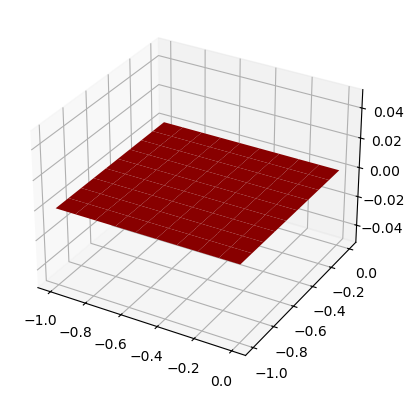

In [ ]:
H = HyperPlane([0,0,1,0])
H.plot(color="red")

In [ ]:
K = im(L).orthogonal_projector.matrix @ I.basis
# K = K/np.linalg.norm(K)
print(K)

[[6.28837260e-17]
 [1.26201133e-16]
 [6.24500451e-16]]


In [ ]:
((im(L) << I) << P3).location

array([ 0.00031204,  0.00136657, -0.00170584])

In [ ]:
((im(L)<<I) << P3) in im(L)

False

In [ ]:
P1p = I << P1
print(P1p.location)
print(P1p.basis)

[ 0.49863014 -0.50821918 -0.50821918]
[]


In [ ]:
O = I.orthogonal_projector
print(O.matrix @ (P1p.location - I.location))
print(P1p.location - I.location)

[ 0.57534247 -0.04794521 -0.04794521]
[ 0.57534247 -0.04794521 -0.04794521]


In [ ]:
print((im(phi) << I).basis)
print((I).basis)

[[-0.99312707]
 [ 0.08276059]
 [ 0.08276059]]
[[-0.99312707]
 [ 0.08276059]
 [ 0.08276059]]


In [ ]:
P = im(phi).orthogonal_projector
P(I.basis - I.location.reshape((-1,1)))

array([-0.91641474,  0.54303456,  0.54303456])

In [ ]:
I.basis

array([[-0.99312707],
       [ 0.08276059],
       [ 0.08276059]])

In [ ]:

K = ~psi.T(~im(phi))

print(im(L).orthogonal_projector(P2))
print(im(L).orthogonal_projector(Point(P2)).location)

[ 0.35 -0.1  -0.05]
[ 0.35 -0.1  -0.05]


In [ ]:
P4 = im(L).orthogonal_projector(P3)
P4

In [ ]:
im

False

In [ ]:
print(P4.location)

[ 0.35 -0.1  -0.05]


In [ ]:
P = im(L).orthogonal_projector
X = P4.location
# print(P.translation, im(L).location)
print(P(X), X)
print(im(L).location)
print(P(im(L).location), im(L).location)
print(P(P.translation), P.translation)
print(P(X - P.translation), X - P.translation)
print(P(X), X)
print(X)

[ 0.2 -0.4 -0.5] [ 0.2 -0.4 -0.5]
[ 0.2 -0.4 -0.5]
[ 0.2 -0.4 -0.5] [ 0.2 -0.4 -0.5]
[ 0.2 -0.4 -0.5] [ 0.2 -0.4 -0.5]
[ 0.35 -0.1  -0.05] [-2.77555756e-17 -5.55111512e-17 -1.11022302e-16]
[ 0.2 -0.4 -0.5] [ 0.2 -0.4 -0.5]
[ 0.2 -0.4 -0.5]


In [ ]:
np.vstack([np.array([1,2,3]).reshape((-1,1)), 0]).ravel()

array([1, 2, 3, 0])

In [ ]:
np.hstack([np.array([1,2,3]), 0])

array([1, 2, 3, 0])

In [ ]:

self, other = im(phi), im(L)

U1 = self.orthogonal_projection_matrix
U2 = other.orthogonal_projection_matrix

U = np.vstack([np.identity(U1.shape[0])-U1, np.identity(U2.shape[0])-U2])

x1 = self.location
x2 = other.location
X = np.hstack([x1-U1@x1, x2-U2@x2])

# print(x1-U1@x1)
print(X.shape)
print(U.T.shape)

(6,)
(3, 6)


In [ ]:
U = np.vstack([np.identity(U1.shape[0])-U1, np.identity(U2.shape[0])-U2])
U

array([[ 0.00000000e+00,  2.95967992e-16, -3.07817651e-16],
       [ 2.83369548e-16,  5.00000000e-01, -5.00000000e-01],
       [-3.20416095e-16, -5.00000000e-01,  5.00000000e-01],
       [ 1.15268834e-01, -2.34094601e-02, -3.18486934e-01],
       [-2.34094601e-02,  9.99380600e-01, -8.42697473e-03],
       [-3.18486934e-01, -8.42697473e-03,  8.85350566e-01]])

In [ ]:
AffineMap([[1,2,3]]).matrix

array([[1, 2, 3]])

In [ ]:
im(AffineMap([[1,2,3]])).basis

array([[-1.]])

In [ ]:
J[:,1].ndim

1

In [ ]:
np.array([1,2,3]).reshape((1,-1))

array([[1, 2, 3]])

In [ ]:
AffineMap([[1],[2],[3]]).image().basis

array([[0.26726124],
       [0.53452248],
       [0.80178373]])

In [ ]:
phi = Transformation(matrix, translation)
im(J.T) & psi()

In [ ]:
dim(AffineSpace(np.array([1,2,3])))

TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
np.isclose(1e-7,0)

False

In [ ]:

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1, projection="3d")
# ax.grid()
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)

# E0 = np.identity(100)[0:3, :] @ Sphere(100)
# E0.plot(ax)
E1 = 4 * Sphere(3) + [1,0,0]
E1.plot(ax, color="red", alpha=0.5)

A1 = HyperPlane([1,2,3,4])
A1.plot(ax, color="blue", alpha=0.2)

E2 = E1.inter(A1)
E2.plot(ax, color="black")

L = Line([1,1,0], [0,1,2])
L.plot(ax, color="orange", scale=100)

Ps = (E1).inter(L)
Ps = L.inter(E1)
Ps.plot(ax, color="green")
ax.scatter(*Ps.location.ravel(), c="green")
# ax.scatter(*Ps[:,1], c="green")
# ax.scatter(*Ps[1].squeeze(), c="green")



In [ ]:
embedded_sphere_transformation(Ps)

array([[2.23606798, 0.        , 0.        ],
       [2.23606798, 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])

In [ ]:
Ps.is_pair_point()

True

In [ ]:
E6 = Ellipsoid(np.random.uniform(-20,20, size=(10,20)))
L1 = Line(np.random.uniform(-1,1, size=10))

K = E6.inter(L1)
print(K.is_pair_point())
print(K.type())

True
HyperObjectTypes.PairPoints


In [ ]:
K = AffineSpace([1,1,0]).matrix @ Sphere(1) + [1,10,0]# Pair Point
# print(K)
print(radius(K))

K.plot(color="red")

1.4142135623730945


In [ ]:
self = K
r = radius(self)
p1 = r * self.matrix + self.location
p2 = - r * self.matrix - self.location
print(*p1)
print(*p2)

[1.] [0.] [0.]
[-1.] [-0.] [-0.]


In [ ]:
print(Ps)

[[[-2.64575131]
  [ 2.64575131]]

 [[-1.64575131]
  [ 3.64575131]]

 [[ 2.        ]
  [ 2.        ]]]


In [ ]:
Ps[:,0]

array([[-2.64575131],
       [-1.64575131],
       [ 2.        ]])

In [ ]:
S1 = Sphere(3)
S2 = Sphere(3)

S2.distance(S1, method="lower_bound")

2.0

33.51032163829113

In [ ]:
S = Ellipsoid(np.diag([1,3,2, 0]))
print(radii(S))
print(radii(np.diag([1,3,2, 0])))

[1. 2. 3.]
[1. 2. 3.]


In [ ]:
EK = Ellipsoid(np.diag([1,3,5,0,4.2]))
print(EK.Q)
print(radii(EK))
EK.type()
print(dim(EK) < dim(codomain(EK)))
# print(radius(EK))

[[1.         0.         0.         0.         0.        ]
 [0.         0.11111111 0.         0.         0.        ]
 [0.         0.         0.04       0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.05668934]]
[1.  3.  4.2 5. ]
True


In [ ]:
print(E.Q)
print(quadratic_form(E))
# print(embedded_sphere_transformation(E))

[[ 0.02745438 -0.00563385 -0.01807598]
 [-0.00563385  0.04951321 -0.02542892]
 [-0.01807598 -0.02542892  0.04227941]]
[[ 0.02745438 -0.00563385 -0.01807598]
 [-0.00563385  0.04951321 -0.02542892]
 [-0.01807598 -0.02542892  0.04227941]]
[[ 8.41071938  3.71248329 -0.6908454 ]
 [ 5.88382958 -2.76840264 -2.5916204 ]
 [ 8.26018608 -1.80817305  2.54947763]]


In [ ]:
print(EK.embedded_matrix)
print(projection_matrix(EK))

[[0.  0.  0.  1.  0. ]
 [0.  0.  3.  0.  0. ]
 [5.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  4.2 0.  0.  0. ]]
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [ ]:
print(dim(E))
print(dim(codomain(E)))
print(dim(E.inter(P)))
print(dim(codomain(E.inter(P))))
print(E.embedded_matrix)
print(E.inter(P).embedded_matrix)

3
3
2
3
[[ 8.41071938  3.71248329 -0.6908454 ]
 [ 5.88382958 -2.76840264 -2.5916204 ]
 [ 8.26018608 -1.80817305  2.54947763]]
[[ 2.11080360e-15 -1.49549825e-15  0.00000000e+00]
 [-4.15378347e+00 -2.54336640e+00  0.00000000e+00]
 [-4.78640653e+00  2.20720769e+00  0.00000000e+00]]


In [ ]:
print(E.inter(P) in P)
print(P in P)

True
True


In [ ]:
M = orthogonal_complement(K)
M.location + 0.08888 in M
print(M + [1,1,1] in M)

True


In [ ]:
E.inter(P) in P

True

In [ ]:
(basis(P)@np.array([1,2])) 

array([ 0., -1., -2.])

In [ ]:
P.projection_matrix @ P.location

array([[0.],
       [0.],
       [0.]])

In [ ]:
coker(K2).projection_matrix @ (K2.location - K2.location) + K2.location

array([[-5.],
       [ 0.],
       [ 0.]])

In [ ]:
(K.location) in K

True

In [ ]:
basis(orthogonal_complement(K))


array([[0.57735027],
       [0.57735027],
       [0.57735027]])

In [ ]:
S @ K2.location.ravel()

-2.88675134594813

In [ ]:
np.random.seed(21)

p, n, m = 3, 8, 10
print(m-n+p)

x_min = -2*np.ones(m)
x_max = 10*np.ones(m)
V = np.random.uniform(-1,1, size=(n, p))
N = np.random.uniform(-5,10, size=(n, m))
b = 10 * np.random.uniform(-5,4, size=n)
# b = 0 * np.random.uniform(-5,4, size=n)

# V1 = V[:3, :]
# V2 = V[3:6, :]
# V3 = V[6:9, :]
# V4 = V[7:, :]

# N1 = N[:3, :]
# N2 = N[3:6, :]
# N3 = N[6:9, :]
# N4 = N[7:, :]

# K1 = np.linalg.inv(V1) @ N1
# K2 = np.linalg.inv(V2) @ N2
# K3 = np.linalg.inv(V3) @ N3
# K4 = np.linalg.inv(V4) @ N4

# B12 = ker(K1 - K2)
# B23 = ker(K2 - K3)
# B34 = ker(K3 - K4)
# A = (B12.inter(B23).inter(B34)).matrix


s = default_timer()
P_ICH = force_polytope(V.T, N, x_min, x_max, torque_bias=-b, tol=0.001)
print(default_timer() - s)

# P_CS = force_polytope(A.T, np.identity(m), x_min + np.linalg.pinv(N)@b, x_max + np.linalg.pinv(N)@b, tol=0.001)
# P_CS = SkuricPolytope(vertices = np.linalg.pinv(V) @ (N @ P_CS.muscle_force_vertices))

K = coker(N.T @ coker(V))
# K = coker(basis(np.linalg.pinv(N)) @ coker(V))
print("Dim K:", dim(K))
print(m-(n-p))

s = default_timer()
P_CS2 = force_polytope(K.matrix.T, np.identity(m), x_min + np.linalg.pinv(N) @ b, x_max + np.linalg.pinv(N) @ b, tol=0.001)
print(default_timer() - s)
s = default_timer()
P_CS2 = SkuricPolytope(vertices = np.linalg.pinv(V) @ N @ P_CS2.muscle_force_vertices)
print(default_timer() - s)

Df = np.array([1,0,0])
Df_in_V = V @ Df 
K_Df = coker(N.T @ coker(im(Df_in_V)))
print("Dim K_Df:", dim(K_Df))
print(dim(N @ K_Df))
print(K_Df.matrix.shape)

t_r = np.random.uniform(size=3)
K_Df_tr = K_Df.matrix @ t_r

fff2 = (np.linalg.pinv(V) @ N @ K_Df_tr).ravel()
# print(basis(N @ K_Df))

fff = basis(np.linalg.pinv(V) @ N @ K_Df).ravel()
print(fff)


5
0.015100399999937508
Dim K: 5
5
0.0869423000003735
0.00020950000180164352
Dim K_Df: 3
1
(10, 3)
[-1.00000000e+00 -3.40698761e-16  6.41068903e-18]


In [ ]:
from pycapacity.algorithms import vertex_enumeration_vepoli2

s = default_timer()
x_vertex, b_vertex = vertex_enumeration_vepoli2(K.matrix, x_min, x_max, -np.linalg.pinv(N)@b)
print(default_timer() - s)
print(b_vertex.shape)
# print(VE[0].shape)
P_CS3 = SkuricPolytope(vertices = np.linalg.pinv(V) @ (N @ b_vertex))



0.033944499999051914
(10, 26)


In [ ]:
# print(rank(N), rank(N.T), N.shape)
# print(rank(N.T @ N), (N.T @ N).shape)

# L = np.linalg.pinv(N)
# print(rank(L @ N), (L @ N).shape)

# print(basis(L).round(1))
# print(basis(N.T).round(1))


In [ ]:
a = np.random.uniform(size=V.shape[1])
Va = V @ a
# print(a in im(V))
# print(a in coker(V))
print(Va in coker(V))
print(Va in im(V))

False
True


In [ ]:
%matplotlib qt5
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1, projection="3d")
fig.suptitle("Force capacities parametrization by an ellipsoid.")

plot_polytope(polytope=P_ICH, plot=ax, edge_color="blue", alpha=0.1)
plot_polytope(polytope=P_CS2, plot=ax, edge_color="red", face_color="red", alpha=0.1)
plot_polytope(polytope=P_CS3, plot=ax, edge_color="green", face_color="green", alpha=0.1)

ax.scatter(0, 0, 0, c="blue")
ax.set_xlim(-100,100)
ax.set_ylim(-100,100)
ax.set_zlim(-100,100)
fff=100*(fff/np.linalg.norm(fff))
fff2=100*(fff2/np.linalg.norm(fff2))
Df = 100*(Df/np.linalg.norm(Df))
ax.plot([0, Df[0]], [0, Df[1]], [0, Df[2]], c="red")
ax.plot([0, fff[0]], [0, fff[1]], [0, fff[2]], c="black")
ax.plot([0, fff2[0]], [0, fff2[1]], [0, fff2[2]], c="green")
ax.scatter(*fff, c="black")
ax.scatter(*fff2, c="green")
ax.scatter(*Df, c="red")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.legend()

using provided 3d axis
using provided 3d axis
using provided 3d axis


In [ ]:
l = np.random.uniform(size=n)
k1 = N.T @ l
k2= np.linalg.pinv(N) @ l
print(k1)
print(k2)
print(k1 / np.linalg.norm(k1))
print(k2 / np.linalg.norm(k2))

print(k1 in im(N.T))
print(k2 in im(N.T))
print(k1 in im(np.linalg.pinv(N)))
print(k2 in im(np.linalg.pinv(N)))

[19.80574305  4.39270741 14.87703508  4.32776106 15.49610747  6.01428912
  7.30632955 13.04295509 -0.90170542  6.25371145]
[ 0.0550476   0.01971319 -0.00434587  0.02384395  0.01297598 -0.0197613
 -0.00553476  0.04073468 -0.04823112  0.00649663]
[ 0.57381607  0.12726642  0.43102052  0.12538478  0.44895642  0.17424722
  0.21168048  0.37788318 -0.0261244   0.18118382]
[ 0.59278251  0.21228234 -0.04679865  0.25676466  0.1397324  -0.21280041
 -0.05960133  0.43865316 -0.51937898  0.06995925]
True
True
False
True
True


In [ ]:
from scipy.spatial import ConvexHull, HalfspaceIntersection
from cvxopt import matrix
import cvxopt.glpk

def stack(A, B, dir='v'):
    """
    Helping function enabling vertical and horizontal stacking of numpy arrays
    """
    if A is None or not len(A):
        return B
    elif B is None or not len(B):
        return A
    elif dir == 'v':
        return  np.vstack((A, B))
    else:
        return  np.hstack((A, B))
        

def iterative_convex_hull_method2(A, B, y_min, y_max, tol, P = None, bias = None,  G_in = None, h_in = None, G_eq = None, h_eq = None, max_iter=1000, verbose=False):

    y_min = np.array(y_min).ravel()
    y_max = np.array(y_max).ravel()
    
    n, p = A.shape
    nB, m = B.shape

    
    
    if n != nB:
        raise ValueError('ICHM: Matrix A and B must have same number fo rows. In your case A: {}, B: {} '.format(A.shape,B.shape))

    if p > n or n > m:
        raise ValueError('ICHM: Matrix A and B dimensions must be colB >= rowB = rowA >= colA. In your case A: {}, B: {} '.format(A.shape,B.shape))

    if m != len(y_max) or m != len(y_min):
        raise ValueError('ICHM: Limits dimensios are not valid, should have {:d} entries. In your case y_min:{} and y_max:{}'.format(L,len(y_min),len(y_max)))

    if np.min(y_max - y_min) < 0:
        raise ValueError('ICHM: Limits not valid, minimal value is higher than maximal value.')


    if bias is None:
        bias = np.zeros((n,1))  
    else:
        bias = np.array(bias).reshape((n,1))
    x_bias = -np.linalg.pinv(A).dot(bias)
    
    # The Cube inequalities
    G = matrix(np.vstack((-np.identity(m),np.identity(m))))
    h = matrix(np.hstack([-y_min, y_max]))

    linprog_count = 0
    solvers_opt={'tm_lim': 100000, 'msg_lev': 'GLP_MSG_OFF', 'it_lim':10000}

    M = (np.linalg.pinv(A) @ B) # f map
    # print("Here", M.shape)
    y_vert, x_p = [],[]

    U = basis(coim(A))
    K_orth = coim(B.T @ coker(im(A))).matrix
    Aeq = matrix(K_orth)
    beq = matrix(np.zeros(K_orth.shape[0]))
    for i in range(p):
        # Replace the a basis vector in the domain of B
        c = M.T @ U[:, i]
        
        linprog_count = linprog_count + 2
        # c = matrix((u[:,i].T).dot(M))
        res = cvxopt.glpk.lp(c=-matrix(c),  A=Aeq, b=beq, G=G,h=h, options=solvers_opt)
        if res[1] is not None:
            y_vert = stack(y_vert, res[1],'h')
        res = cvxopt.glpk.lp(c=matrix(c),  A=Aeq, b=beq, G=G,h=h, options=solvers_opt)
        if res[1] is not None:
            y_vert = stack(y_vert, res[1],'h')
    x_p  = M.dot(y_vert) + x_bias
    z_vert = B.dot(y_vert) + bias
    
    
    # K = im(B.T @ coker(A)).matrix.T
    # Aeq = matrix(K)
    # beq = matrix(np.zeros(K.shape[0]))

    try:
        hull = ConvexHull(x_p.T, incremental=True)
    except:
        if(verbose): print("ICHM: Convex hull issue at init - continuing with a QJ option!")
        try:
            hull = ConvexHull(x_p.T, incremental=True, qhull_options="QJ")
        except:
            if(verbose): print("ICHM: Search stopped prematurely - inital convex hull not found!")
            z_vert = B.dot(y_vert) + bias
            x_vert  = M.dot(y_vert) + x_bias
            return x_vert, [], [], [], [], []

    face_final = {}
    max_delta = tol*100 
    while max_delta > tol and linprog_count <= max_iter:
        x_center = np.mean(x_p,axis=1)
        
        y_vert_new = []
        max_delta = 0
        for face, equation in zip(hull.simplices,hull.equations):
            face_key = str(np.sort(equation))
            
            # check if this face (face index) has been found as final
            if face_key in face_final.keys():
                continue
            
            # update linprog counter
            linprog_count = linprog_count + 1

            # calculate the normal vector to the face
            face_normal = equation[:-1]

            # calculate the projection of the centroid on the normal of the face
            # to figure out the direction of the LP
            dir = np.mean(face_normal.dot(x_p[:,face[0]] - x_center)) > 0
            # use linear programming to find a vertex in the face_normal direciton
            c = M.T @ face_normal
            
            if dir:
                res = cvxopt.glpk.lp(c=-c,  A=Aeq, b=beq, G=G,h=h, options=solvers_opt)
            else:
                res = cvxopt.glpk.lp(c=c,  A=Aeq, b=beq, G=G,h=h, options=solvers_opt)
                
            res = np.array(res[1])

            # vertex distance from the face
            distance = np.abs( face_normal.dot( M.dot(res) + x_bias) -face_normal.dot( x_p[:,face[0]] ))

            if distance > tol:
                # new vertex found
                y_vert_new = stack(y_vert_new, res, 'h')
            else:
                face_final[face_key] = 1
            
            if distance > max_delta:
                max_delta = distance

        if len(y_vert_new):
            x_p_new = M.dot(y_vert_new) + x_bias

            x_p  = stack(x_p, x_p_new,'h')
            y_vert = stack(y_vert, y_vert_new,'h')

            z_new = B.dot(y_vert_new) + bias
            z_vert = stack(z_vert, z_new,'h')

            try:
                hull.add_points(x_p_new.T)
            except:
                if(verbose): print("ICHM: Convex hull issue - continuing with a QJ option!")
                hull = ConvexHull(x_p.T, incremental=True, qhull_options="QJ")
            
        elif max_delta > tol: 
            if(verbose): print("ICHM: Search stopped prematurely - search stuck at precision: {}!".format(max_delta))
            # raise error here instead
            break 

    if linprog_count >= max_iter:
        if(verbose): print("ICHM: Max iteration number reached: {}".format(max_iter))

    return hull.points.T, hull.equations[:,:-1], -hull.equations[:,-1], hull.simplices, y_vert, z_vert



In [ ]:

from timeit import default_timer

s = default_timer()
P_ICH = force_polytope(V.T, N, x_min, x_max, torque_bias=None, tol=0.01)
print(default_timer() - s)
s = default_timer()
f_vert, H, d, faces , F_vert, t_vert = iterative_convex_hull_method2(V, N, x_min, x_max, tol=0.001)
print(default_timer() - s)

# construct polytope object
poly = SkuricPolytope(vertices=f_vert, H=H, d=d)
poly.torque_vertices = t_vert
poly.muscle_force_vertices = F_vert
poly.face_indices = faces

%matplotlib qt5

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1, projection="3d")
fig.suptitle("Force capacities parametrization by an ellipsoid.")


plot_polytope(polytope=P_ICH, plot=ax, edge_color="blue", alpha=0.1)
# plot_polytope(polytope=P_CS, plot=ax, edge_color="red", face_color="red", alpha=0.1)
plot_polytope(polytope=poly, plot=ax, edge_color="red", face_color="red", alpha=0.1)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.legend()


0.029434500000206754
0.03322939999998198
Visual: no faces found, calculating faces
using provided 3d axis
Visual: no faces found, calculating faces
using provided 3d axis


In [ ]:
A = np.array([[1,2,3],[1,2,2], [5,2,3], [6,3,2]])

u, s, v = np.linalg.svd(A.T)
r = len(s)
V1 = np.array(v.transpose()[:,:r])
V2 = np.array(v.transpose()[:,r:])
print(V2.round(2))
# V2 

U = basis(coim(A))
print(U.round(2))
print(u.round(2))

[[-0.59]
 [ 0.69]
 [ 0.31]
 [-0.28]]
[[ 0.77  0.62  0.15]
 [ 0.44 -0.34 -0.83]
 [ 0.46 -0.71  0.53]]
[[ 0.77  0.62  0.15]
 [ 0.44 -0.34 -0.83]
 [ 0.46 -0.71  0.53]]


In [ ]:
basis(coker(A))

array([[-0.59],
       [ 0.69],
       [ 0.31],
       [-0.28]])